MOC from https://github.com/COSIMA/cosima-recipes/blob/main/DocumentedExamples/Zonally_Averaged_Global_Meridional_Overturning_Circulation.ipynb

In [1]:
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
from dask.distributed import Client
from scipy.interpolate import interp1d

import xarray as xr
import cf_xarray as cfxr

In [2]:
client = Client()
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35813/status,
Dashboard: /proxy/35813/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35379,Workers: 7
Dashboard: /proxy/35813/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:34261,Total threads: 4
Dashboard: /proxy/36395/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:46213,


In [3]:
session_name = '/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db'
master_session = cc.database.create_session(session_name)
control = '01deg_jra55v13_ryf9091_DSW'#_21mbath' #01deg_jra55v13_ryf9091_DSW'
#database for basal melt experiments:
session_name = '/g/data/ik11/databases/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)
basal = '01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb'
icb = '01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb'
basalnogade = '01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb'

In [4]:
psi_args = {
    "mom5-control": {
        "expt": "01deg_jra55v13_ryf9091_DSW",
        "session": master_session,
        "variable": "ty_trans_rho",
        "start_time": "1905-01-01",
        "end_time": "1909-12-31",
        "chunks": {"time": 1,"potrho": -1,"grid_yu_ocean": 270,"grid_xt_ocean": -1,}
    },
    "mom5-basal": {
        "expt": '01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb',
        "session": basal_melt_session ,
        "variable": "ty_trans_rho",
        "start_time": "1905-01-01",
        "end_time": "1909-12-31",
        "chunks": {"time": 1,"potrho": -1,"grid_yu_ocean": 270,"grid_xt_ocean": -1,}
    },
    "mom5-iceberg": {
        "expt": '01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb',
        "session": basal_melt_session ,
        "variable": "ty_trans_rho",
        "start_time": "1905-01-01",
        "end_time": "1909-12-31",
        "chunks": {"time": 1,"potrho": -1,"grid_yu_ocean": 270,"grid_xt_ocean": -1,}
    },
    "mom5-basalnogade": {
        "expt": '01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb',
        "session": basal_melt_session ,
        "variable": "ty_trans_rho",
        "start_time": "1905-01-01",
        "end_time": "1909-12-31",
        "chunks": {"time": 1,"potrho": -1,"grid_yu_ocean": 270,"grid_xt_ocean": -1,}
    },
    "mom6": {
        "expt": "global-01-v3",
        "variable": "vmo",
        "start_time": "2001-01-01",
        "end_time": "2002-01-01",
        "frequency": "1 monthly",
        "attrs": {"cell_methods": "rho2_l:sum yq:point xh:sum time: mean"},
    }
}

In [5]:
def load_streamfunction(model):
    expt = psi_args[model]["expt"]
    start_time = psi_args[model]["start_time"]
    end_time = psi_args[model]["end_time"]
    session = psi_args[model]["session"]
    
    psi = cc.querying.getvar(**psi_args[model])
    psi = psi.sel(time=slice(start_time, end_time))
    psi = psi.cf.sum("longitude")

    psiGM = xr.zeros_like(psi)

    varlist = cc.querying.get_variables(session, expt)
    if varlist['name'].str.contains('ty_trans_rho_gm').any():
        GM = True
        psiGM = cc.querying.getvar(expt, 'ty_trans_rho_gm', session, start_time=start_time)
        psiGM = psiGM.cf.sum("longitude")
    else:
        GM = False
    
    ρ0 = 1025 # mean density of sea-water [kg/m³]
    
    # convert to Sv
    psi = psi / (1e6 * ρ0)
    psiGM = psiGM / (1e6 * ρ0)
    
    return psi, psiGM, GM


In [6]:
def sum_in_vertical(psi, psiGM, GM):
    psi_avg = psi.cf.cumsum("vertical").mean("time") - psi.cf.sum("vertical").mean("time")

    if GM:
        psi_avg = psi_avg + psiGM.cf.mean("time")

    psi_avg.load()
    
    return psi_avg

In [7]:
model = 'mom5-control'
#session = 'master-session'
psi, psiGM, GM = load_streamfunction(model)
psi_avg = sum_in_vertical(psi, psiGM, GM)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

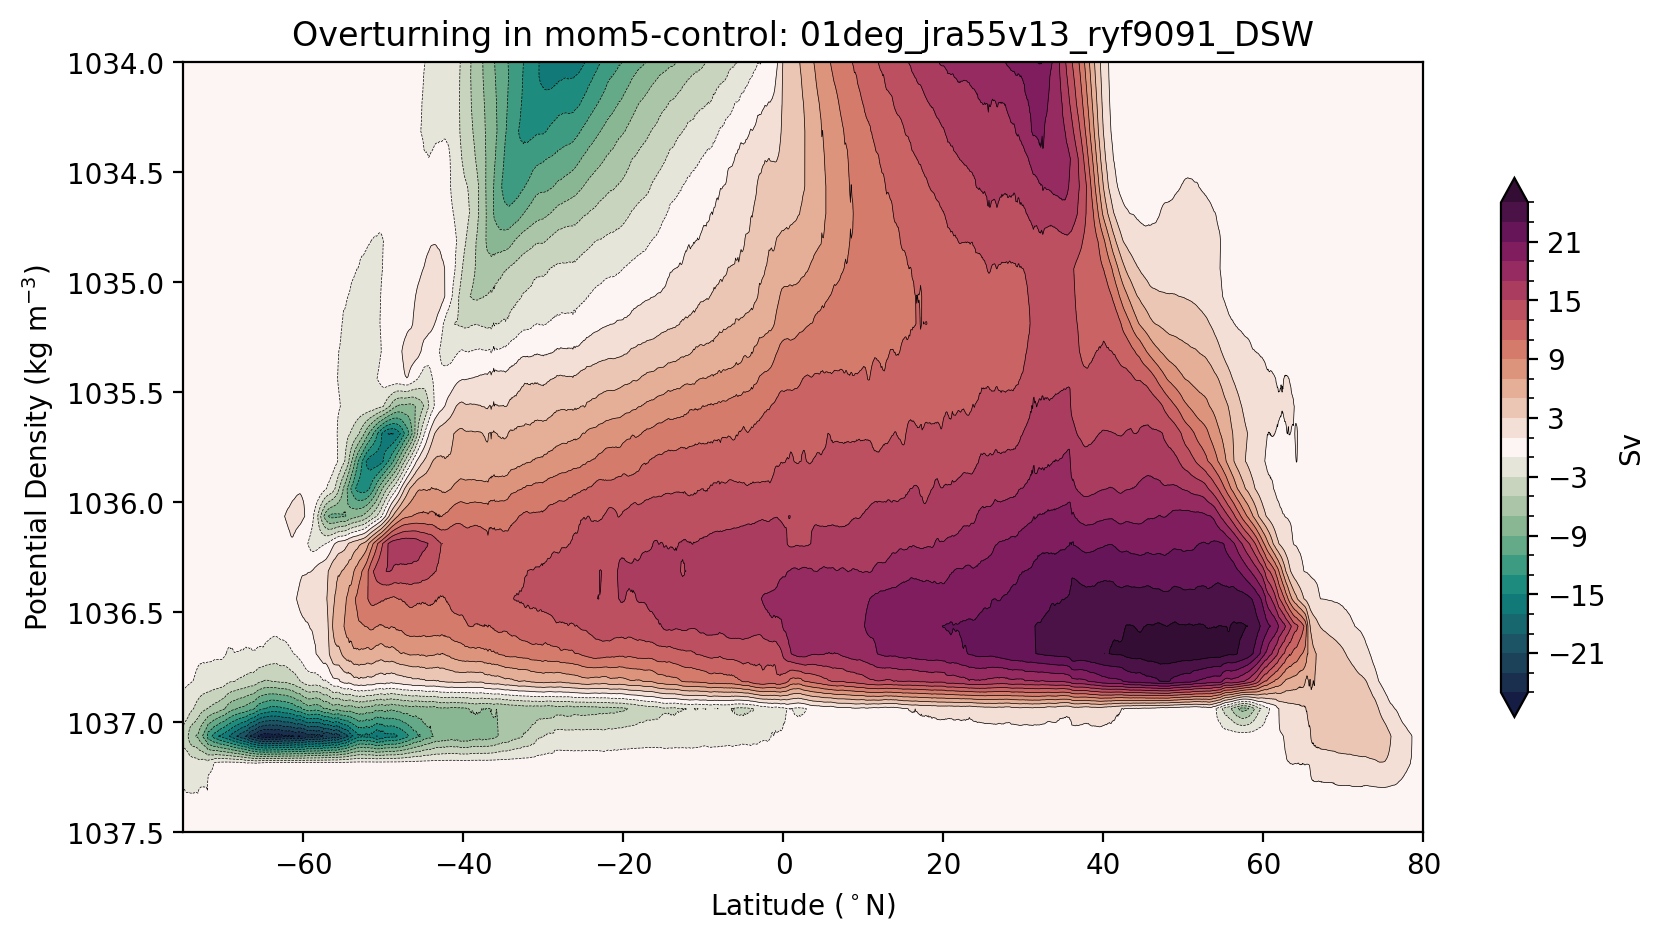

In [8]:
plt.figure(figsize=(10, 5))

max_psi = 25 # Sv

# how we compute the levels may seem complicated, we just want to avoid a 0 contour
# so that the plot looks soothing to the eye
levels =  np.hstack((np.arange(-max_psi, 0, 2), np.flip(-np.arange(-max_psi, 0, 2))))
cbarticks = np.hstack((np.flip(-np.arange(3, max_psi, 6)), np.arange(3, max_psi, 6)))

psi_avg.plot.contourf(levels=levels,
                      cmap=cm.cm.curl, extend='both',
                      cbar_kwargs={'shrink': 0.7, 'label': 'Sv', 'ticks': cbarticks})

psi_avg.plot.contour(levels=levels, colors='k', linewidths=0.25)

plt.gca().invert_yaxis()

plt.ylim((1037.5, 1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75, 80])
plt.title(f'Overturning in {model}: {psi_args[model]["expt"]}');

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

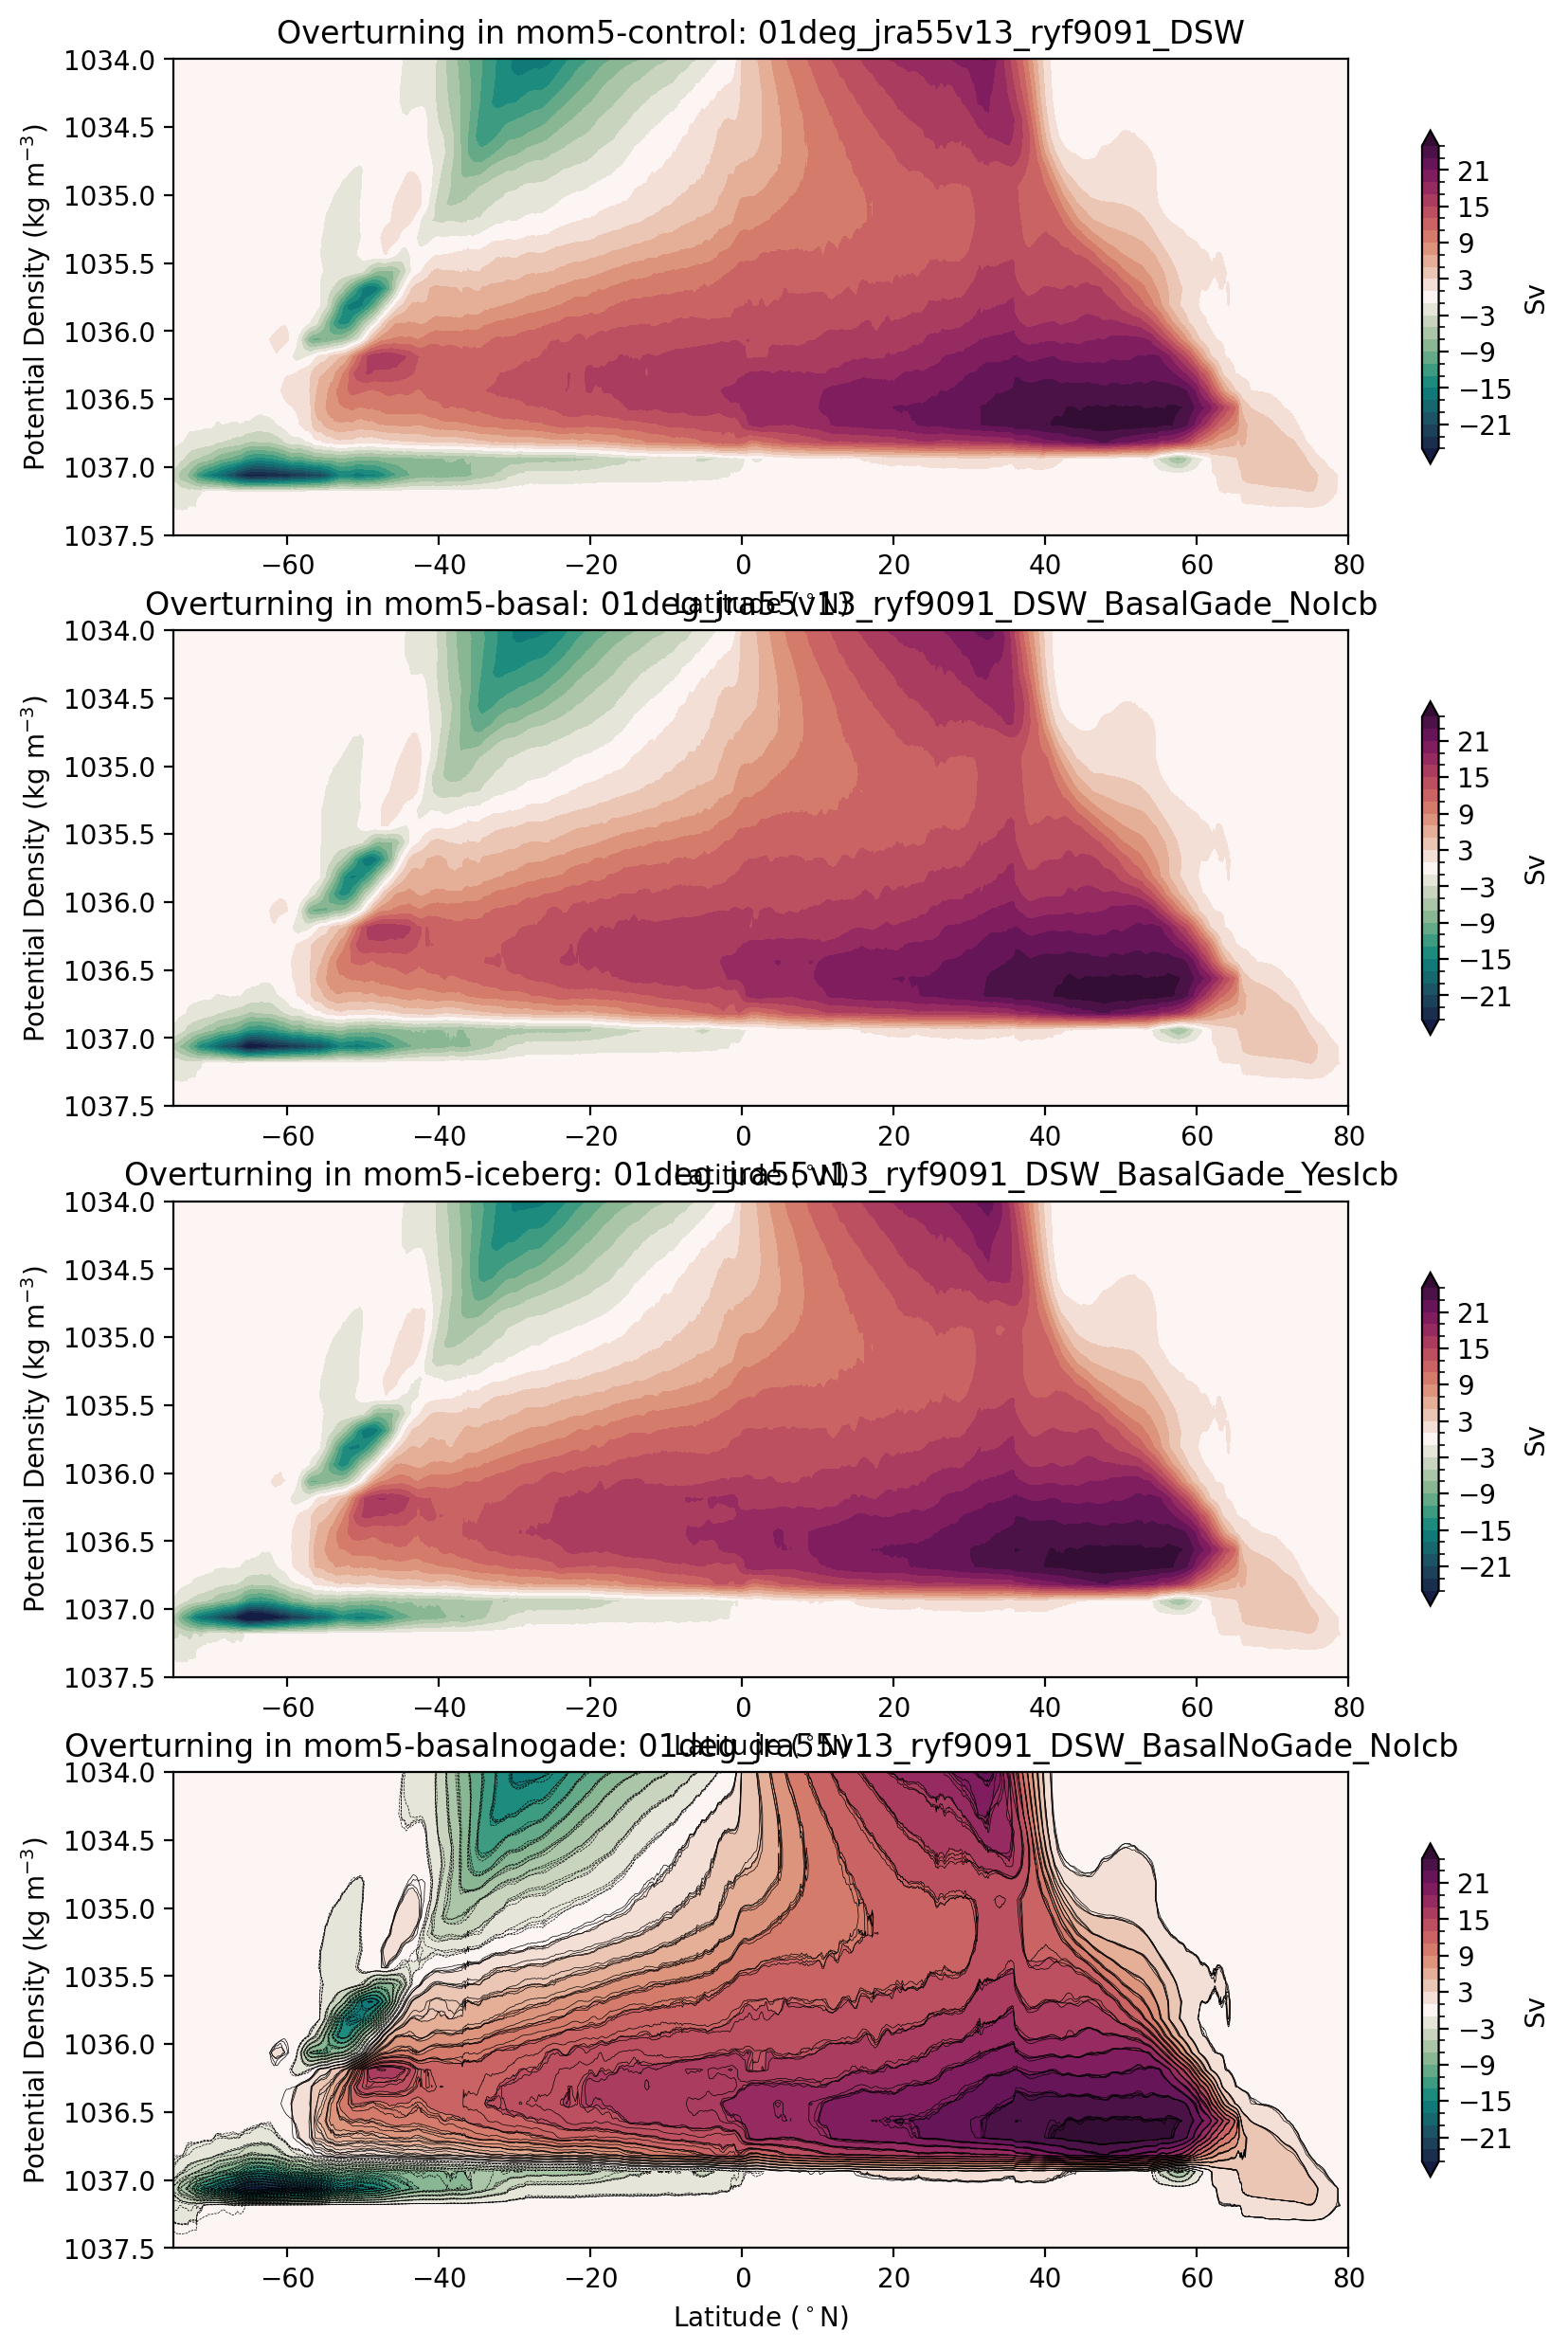

In [9]:
fig, axes = plt.subplots(nrows = 4, figsize=(10, 15))

max_psi = 25 # Sv

# how we compute the levels may seem complicated, we just want to avoid a 0 contour
# so that the plot looks soothing to the eye
levels =  np.hstack((np.arange(-max_psi, 0, 2), np.flip(-np.arange(-max_psi, 0, 2))))
cbarticks = np.hstack((np.flip(-np.arange(3, max_psi, 6)), np.arange(3, max_psi, 6)))
for i in np.arange(4):
    model = ['mom5-control','mom5-basal','mom5-iceberg','mom5-basalnogade'][i]
    #session = 'master-session'
    psi, psiGM, GM = load_streamfunction(model)
    psi_avg = sum_in_vertical(psi, psiGM, GM)
    psi_avg.plot.contourf(ax = axes[i], levels=levels,
                          cmap=cm.cm.curl, extend='both',
                          cbar_kwargs={'shrink': 0.7, 'label': 'Sv', 'ticks': cbarticks})
    
    psi_avg.plot.contour(levels=levels, colors='k', linewidths=0.25)
    
    plt.gca().invert_yaxis()
    
    axes[i].set_ylim((1037.5, 1034))
    axes[i].set_ylabel('Potential Density (kg m$^{-3}$)')
    axes[i].set_xlabel('Latitude ($^\circ$N)')
    axes[i].set_xlim([-75, 80])
    axes[i].set_title(f'Overturning in {model}: {psi_args[model]["expt"]}');

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

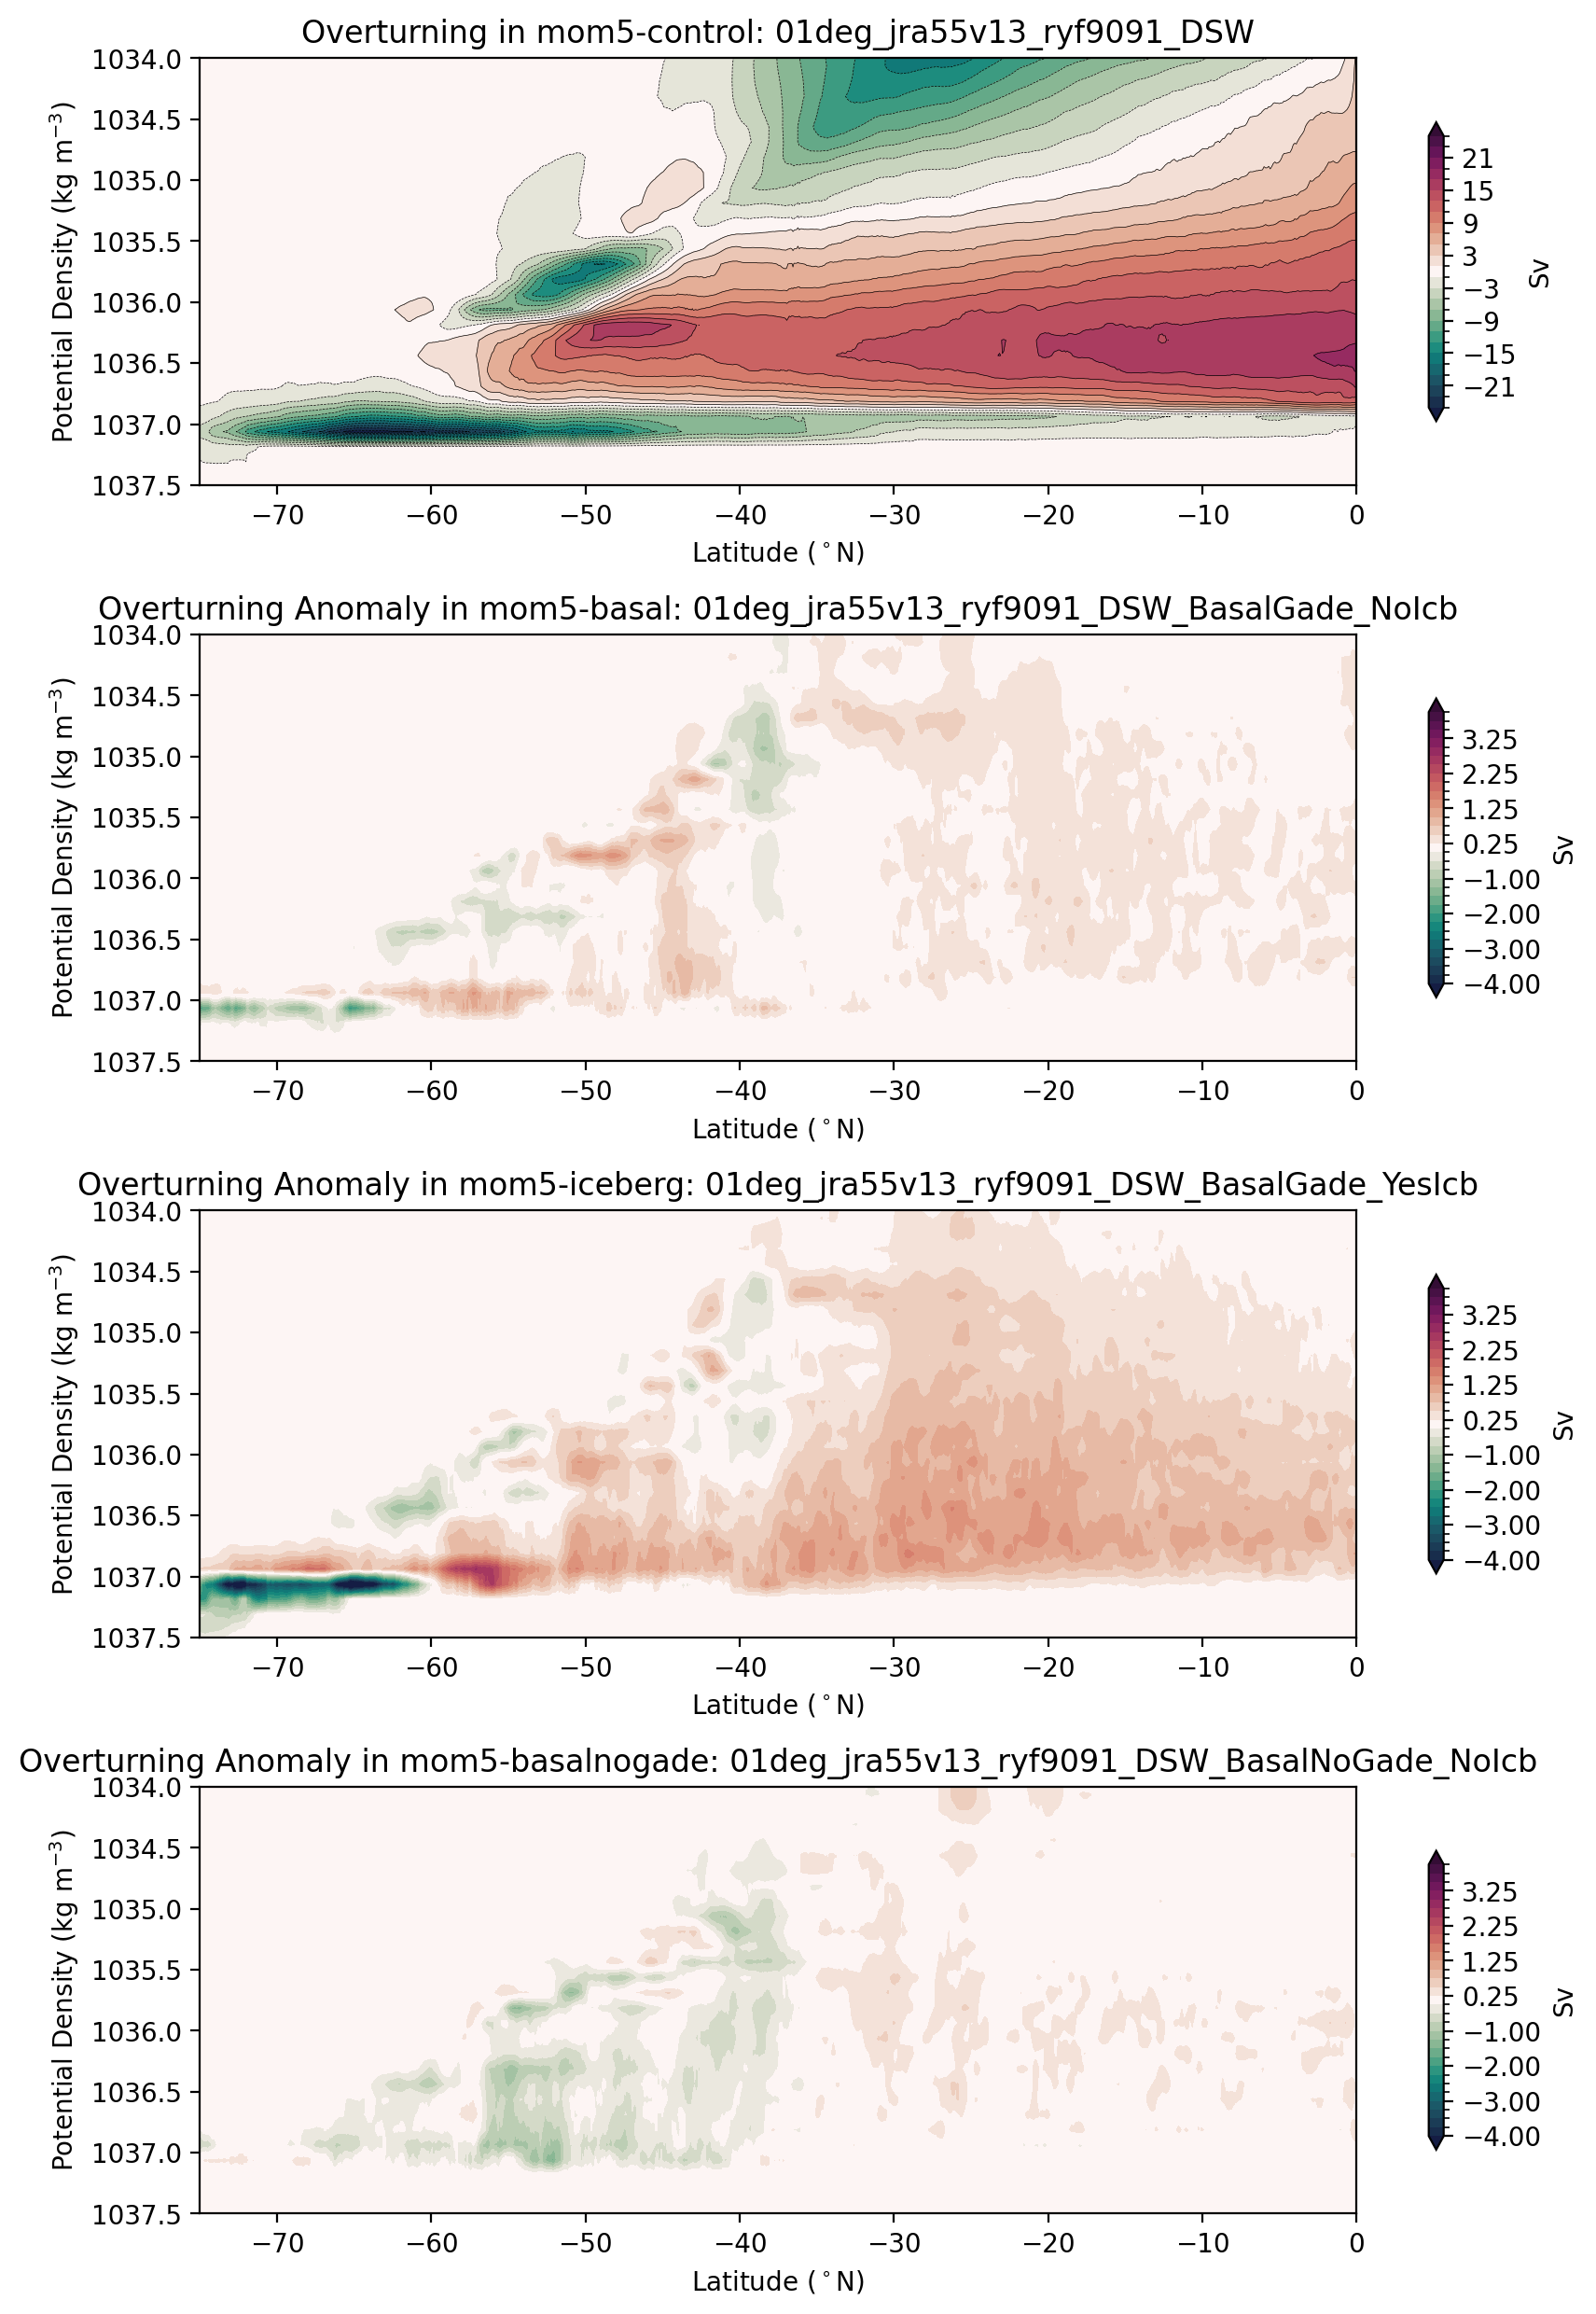

In [8]:
fig, axes = plt.subplots(nrows = 4, figsize=(10, 15))

max_psi = 25 # Sv

# how we compute the levels may seem complicated, we just want to avoid a 0 contour
# so that the plot looks soothing to the eye
levels =  np.hstack((np.arange(-max_psi, 0, 2), np.flip(-np.arange(-max_psi, 0, 2))))
cbarticks = np.hstack((np.flip(-np.arange(3, max_psi, 6)), np.arange(3, max_psi, 6)))
model = 'mom5-control'
i = 0
psi, psiGM, GM = load_streamfunction(model)
psi_avg_control = sum_in_vertical(psi, psiGM, GM)
psi_avg_control.plot.contourf(ax = axes[i], levels=levels,
                      cmap=cm.cm.curl, extend='both',
                      cbar_kwargs={'shrink': 0.7, 'label': 'Sv', 'ticks': cbarticks})

psi_avg_control.plot.contour(ax = axes[i], levels=levels, colors='k', linewidths=0.25)

plt.gca().invert_yaxis()

axes[i].set_ylim((1037.5, 1034))
axes[i].set_ylabel('Potential Density (kg m$^{-3}$)')
axes[i].set_xlabel('Latitude ($^\circ$N)')
axes[i].set_xlim([-75, 0])
axes[i].set_title(f'Overturning in {model}: {psi_args[model]["expt"]}');

max_psi = 4 # Sv

# how we compute the levels may seem complicated, we just want to avoid a 0 contour
# so that the plot looks soothing to the eye
levels =  np.hstack((np.arange(-max_psi, 0, 0.25), np.flip(-np.arange(-max_psi, 0, 0.25))))
cbarticks = levels[::4]#np.hstack((np.flip(-np.arange(3, max_psi, 6)), np.arange(3, max_psi, 6)))


for i in np.arange(1,4):
    model = ['mom5-control','mom5-basal','mom5-iceberg','mom5-basalnogade'][i]
    #session = 'master-session'
    psi, psiGM, GM = load_streamfunction(model)
    psi_avg = sum_in_vertical(psi, psiGM, GM)
    (psi_avg-psi_avg_control).plot.contourf(ax = axes[i], levels=levels,
                          cmap=cm.cm.curl, extend='both',
                          cbar_kwargs={'shrink': 0.7, 'label': 'Sv', 'ticks': cbarticks})
    
    #psi_avg.plot.contour(ax = axes[i], levels=levels, colors='k', linewidths=0.25)
    
    plt.gca().invert_yaxis()
    
    axes[i].set_ylim((1037.5, 1034))
    axes[i].set_ylabel('Potential Density (kg m$^{-3}$)')
    axes[i].set_xlabel('Latitude ($^\circ$N)')
    axes[i].set_xlim([-75, 0])
    axes[i].set_title(f'Overturning Anomaly in {model}: {psi_args[model]["expt"]}');

fig.subplots_adjust(hspace = 0.35)

In [14]:
print('hi')

hi
